# Problématique

<h3> Prédire le nombre de lettres dans l'image (régression)</h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : MLP
- Évaluation du modèle : MAE métrique


# Import

In [44]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss


In [22]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)

<module 'ressources' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\ressources.py'>

In [3]:
# BIDOUILLE SALE!! pour importer des fichiers qui ne sont pas dans le meme repertoire. les fichiers devront être mieux rangés par la suite
# import sys
# sys.path.insert(1, '../')

# import preprocessing as pp
# import ressources as rss

# Chargement du dataframe

In [26]:
# initialisation des variables globales
rss.init()

word_df = pd.DataFrame(pp.parse_my_word_file(rss.WORDS_META_FILENAME), columns=rss.WORD_COLUMNS)
word_df = pp.prepro_word(word_df)

d:\GitHub\OCRpyMAN\notebooks\letter_detection\..\preprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['word_img_path'] = word_df['word_id'].apply(lambda x: get_word_image_path_by_word_id(x))
d:\GitHub\OCRpyMAN\notebooks\letter_detection\..\preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['form_img_path'] = word_df['word_id'].apply(lambda x: get_form_img_path_by_word_id(x))


Problème indice 3600
Problème indice 94929
Certains fichiers des mots sont inaccessibles : on les retire du dataframe


In [27]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    img_size=img_size,
    pickle_name="test",
    with_edge_detection = False
)
data_edge = ld_util.get_dataframe_with_preprocessed_imgs(
    img_size=img_size,
    load_pickle_if_exists = False,
    pickle_name="test_edge",
    with_edge_detection = True
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

df_edge = data_edge['df']
preprocessed_imgs_edge = data_edge['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Generating data...
Filtering data: taking only letters
Using 1000 rows
Starting preprocessing of images with tensorflow
Creating pickle dump ../pickle/test.pickle
Generating data...
Filtering data: taking only letters
Using 1000 rows
Starting preprocessing of images with tensorflow
Creating pickle dump ../pickle/test_edge.pickle
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


In [28]:
print(len(df_edge))
print(len(preprocessed_imgs_edge))
print(len(df))
print(len(preprocessed_imgs))

1000
1000
1000
1000


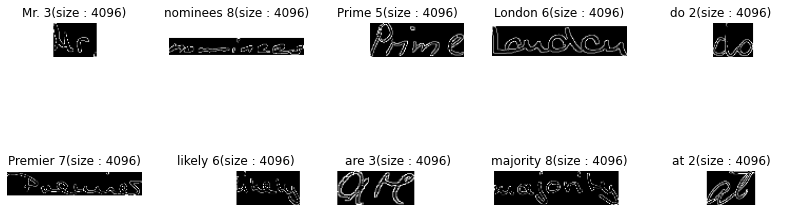

In [34]:

# j = 1
# random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs), size=[10])
# plt.figure(figsize=(14, 5))
# for i in random_indexes:
#     plt.subplot(2, 5, j)
#     plt.axis('off')
#     plt.imshow(preprocessed_imgs[i].reshape(img_size), cmap='gray');
#     plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length))
#     j+=1
    
j = 1
random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs_edge), size=[10])
plt.figure(figsize=(14, 5))
for i in random_indexes:
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(preprocessed_imgs_edge[i].reshape(img_size), cmap='gray');
    plt.title(df_edge.iloc[i].transcription + ' ' + str(df_edge.iloc[i].length) + '(size : ' + str(len(preprocessed_imgs_edge[i])) + ')')
    j+=1

# Model

## MLP

In [36]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
target_edge = df_edge['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)
X_train_edge, X_test_edge, y_train_edge, y_test_edge = train_test_split(preprocessed_imgs_edge, target_edge, test_size=0.2, shuffle=False)

SciKitLearn

In [37]:
from sklearn.neural_network import MLPClassifier 
# tester MLPRegressor


mlp = MLPClassifier(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)

In [38]:
mlp.fit(X_train, y_train)

print(mlp.score(X_test, y_test))
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

0.19


In [39]:
mlp.fit(X_train_edge, y_train_edge)

print(mlp.score(X_test_edge, y_test_edge))
y_pred_edge = mlp.predict(X_test_edge)
y_pred_edge_proba = mlp.predict_proba(X_test_edge)

0.21


Sans tuning, le score avec des images "contours" est légèrement meilleur, mais surtout le temps d'entrainement est 3 fois plus court

In [45]:

mlp_tun = MLPClassifier(
    max_iter=1000,
    random_state=42
)
parameter_space = {
    'hidden_layer_sizes': [(64, 256, 1024),(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_tun, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_edge, y_train_edge)

# Best parameters found:
#  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024), 'learning_rate': 'constant', 'solver': 'adam'}

c:\Users\TiBo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [48]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024), 'learning_rate': 'constant', 'solver': 'adam'}


In [73]:
# GridSearchCV Best parameters found:
#  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024), 'learning_rate': 'constant', 'solver': 'adam'}

best_mlp = MLPClassifier(
    solver='adam', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024, 60),   # best : 0.27 avec (64, 256, 1024, 60)
    max_iter=1000,
    learning_rate='constant',
    random_state=42
)

best_mlp.fit(X_train_edge, y_train_edge)

print(best_mlp.score(X_test_edge, y_test_edge))
y_pred_edge = best_mlp.predict(X_test_edge)
y_pred_edge_proba = best_mlp.predict_proba(X_test_edge)

0.235


# TensorFlow Neural Network

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


x_train, y_train, x_test, y_test = X_train_edge, y_train_edge, X_test_edge, y_test_edge
data_shape = (32 * 128,)

# normalisation
x_train, x_test = x_train / 255.0, x_test / 255.0

# inputs = Input(shape=(X_train.shape[1]))
# first_layer = Dense(16, activation='tanh', name='Dense_1')
# second_layer = Dense(24, activation='tanh', name='Dense_2')
# third_layer = Dense(df.length.max(), activation='linear', name='Dense_3')


model = tf.keras.models.Sequential([
    # tf.keras.layers.Input(shape=img_size),
    tf.keras.layers.Flatten(input_shape=data_shape),  # tester avec global average polling 2D (si extraction de feature)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(30, activation='softmax')
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )



In [80]:
print(x_train.shape)
print(y_train.shape)
print(max(y_train))


(800, 4096)
(800,)
15


In [85]:
model.fit(x_train, y_train, epochs=50)
model.evaluate(x_test, y_test, verbose=2)

Epoch 1/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9550 - accuracy: 0.2700
Epoch 2/500
25/25 [==============================] - 0s 7ms/step - loss: 1.9510 - accuracy: 0.2700
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9478 - accuracy: 0.2650
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9445 - accuracy: 0.2700
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 1.9419 - accuracy: 0.2713
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9392 - accuracy: 0.2763
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 1.9376 - accuracy: 0.2763
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 1.9358 - accuracy: 0.2713
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 1.9323 - accuracy: 0.2825
Epoch 10/500
25/25 [==============================] - 0s 4ms/step - loss: 1.9307 - accuracy: 0.2700
Epoch 11/

[2.540010929107666, 0.2750000059604645]

In [88]:
# EXEMPLE DU COURS

inputs = Input(shape = data_shape, name = "Input")

dense1 = Dense(units = 256, activation = "tanh",kernel_initializer ='normal', name = "Dense_1")
dense2 = Dense(units = 256, activation = "tanh",kernel_initializer ='normal', name = "Dense_2")
dense3 = Dense(units = 30, activation = "softmax",kernel_initializer ='normal', name = "Dense_3")

outputs=dense3(dense2(dense1(inputs)))

model = Model(inputs = inputs, outputs = outputs)

model.compile(loss = 'sparse_categorical_crossentropy',  # fonction de perte
              optimizer = 'adam',                 # algorithme d'optimisation
              metrics = ['accuracy'])             # métrique d'évaluation
                                            

training_history = model.fit(x_train, y_train,          # données d'entraînement
                             epochs = 50,               # nombre d'epochs
                             batch_size = 200,          # taille des batchs
                             validation_split = 0.2)    # proportion de l'échantillon de test
model.evaluate(x_test, y_test, verbose=2)

Epoch 1/50
4/4 [==============================] - 1s 113ms/step - loss: 3.3596 - accuracy: 0.1781 - val_loss: 3.1975 - val_accuracy: 0.1875
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 3.0962 - accuracy: 0.1937 - val_loss: 2.7566 - val_accuracy: 0.1875
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 2.6287 - accuracy: 0.1937 - val_loss: 2.3677 - val_accuracy: 0.1875
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 2.3289 - accuracy: 0.1953 - val_loss: 2.3048 - val_accuracy: 0.1562
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 2.2491 - accuracy: 0.1688 - val_loss: 2.2955 - val_accuracy: 0.1562
Epoch 6/50
4/4 [==============================] - 0s 21ms/step - loss: 2.2111 - accuracy: 0.2000 - val_loss: 2.2617 - val_accuracy: 0.1875
Epoch 7/50
4/4 [==============================] - 0s 25ms/step - loss: 2.1668 - accuracy: 0.1937 - val_loss: 2.2106 - val_accuracy: 0.1875
Epoch 8/50
4/4 [==========

[1.9567025899887085, 0.2750000059604645]